In [ ]:
import pandas as pd

# Load forecast data
bagging_dt = pd.read_csv('results/bagging_dt.csv')
har = pd.read_csv('results/har.csv')
garch = pd.read_csv('results/garch.csv')
rf = pd.read_csv('results/rf.csv')
svr = pd.read_csv('results/svr.csv')
test = pd.read_csv('processed_data/test.csv')[['Date', 'ln_hourly_rv', ln_3_hour]]


# Rename columns for clarity
garch.columns = ['time', 'GARCH']
garch_lstm.columns = ['time', 'GARCH_LSTM']
lstm.columns = ['time', 'LSTM']
har.columns = ['time', 'HAR']
rf.columns = ['time', 'RF']
test.columns = ['time', 'Actual_RV']

# Print the first date from each file.
# We convert the string to datetime for clarity.
print("GARCH first date:       ", pd.to_datetime(garch['time'].iloc[0]))
print("GARCH-LSTM first date:  ", pd.to_datetime(garch_lstm['time'].iloc[0]))
print("LSTM first date:        ", pd.to_datetime(lstm['time'].iloc[0]))
print("HAR first date:         ", pd.to_datetime(har['time'].iloc[0]))
print("RF first date:          ", pd.to_datetime(rf['time'].iloc[0]))
print("Test file first date:   ", pd.to_datetime(test['time'].iloc[0]))

data = pd.merge(test, garch, on='time', how='inner')
data = pd.merge(data, garch_lstm, on='time', how='inner')
data = pd.merge(data, lstm, on='time', how='inner')
data = pd.merge(data, har, on='time', how='inner')
data = pd.merge(data, rf, on='time', how='inner')

# Convert 'time' to datetime format and set as index.
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

GARCH first date:        2022-04-30 00:00:00
GARCH-LSTM first date:   2022-06-29 00:00:00
LSTM first date:         2022-05-12 00:00:00
HAR first date:          2022-04-30 00:00:00
RF first date:           2022-04-30 00:00:00
Test file first date:    2016-07-01 00:00:00


In [20]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Function to calculate evaluation metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    qlike = np.mean(actual/predicted - np.log(actual/predicted) - 1)
    return rmse, mape, r2, qlike

# Models to evaluate
models = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR', 'RF']

# Calculate metrics for each model
metrics = {}
for model in models:
    rmse, mape, r2, qlike = calculate_metrics(data['Actual_RV'], data[model])
    metrics[model] = {'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'QLIKE': qlike}
    print(f'{model}: RMSE={rmse:.6f}, MAPE={mape:.4f}, R2={r2:.4f}, QLIKE={qlike:.4f}')
    



GARCH: RMSE=0.001569, MAPE=2.6607, R2=0.0018, QLIKE=0.4838
GARCH_LSTM: RMSE=0.001414, MAPE=0.5853, R2=0.1887, QLIKE=0.3962
LSTM: RMSE=0.001291, MAPE=1.2912, R2=0.3237, QLIKE=0.3050
HAR: RMSE=0.001170, MAPE=0.7361, R2=0.4444, QLIKE=0.1957
RF: RMSE=0.001236, MAPE=0.5671, R2=0.3806, QLIKE=0.2051


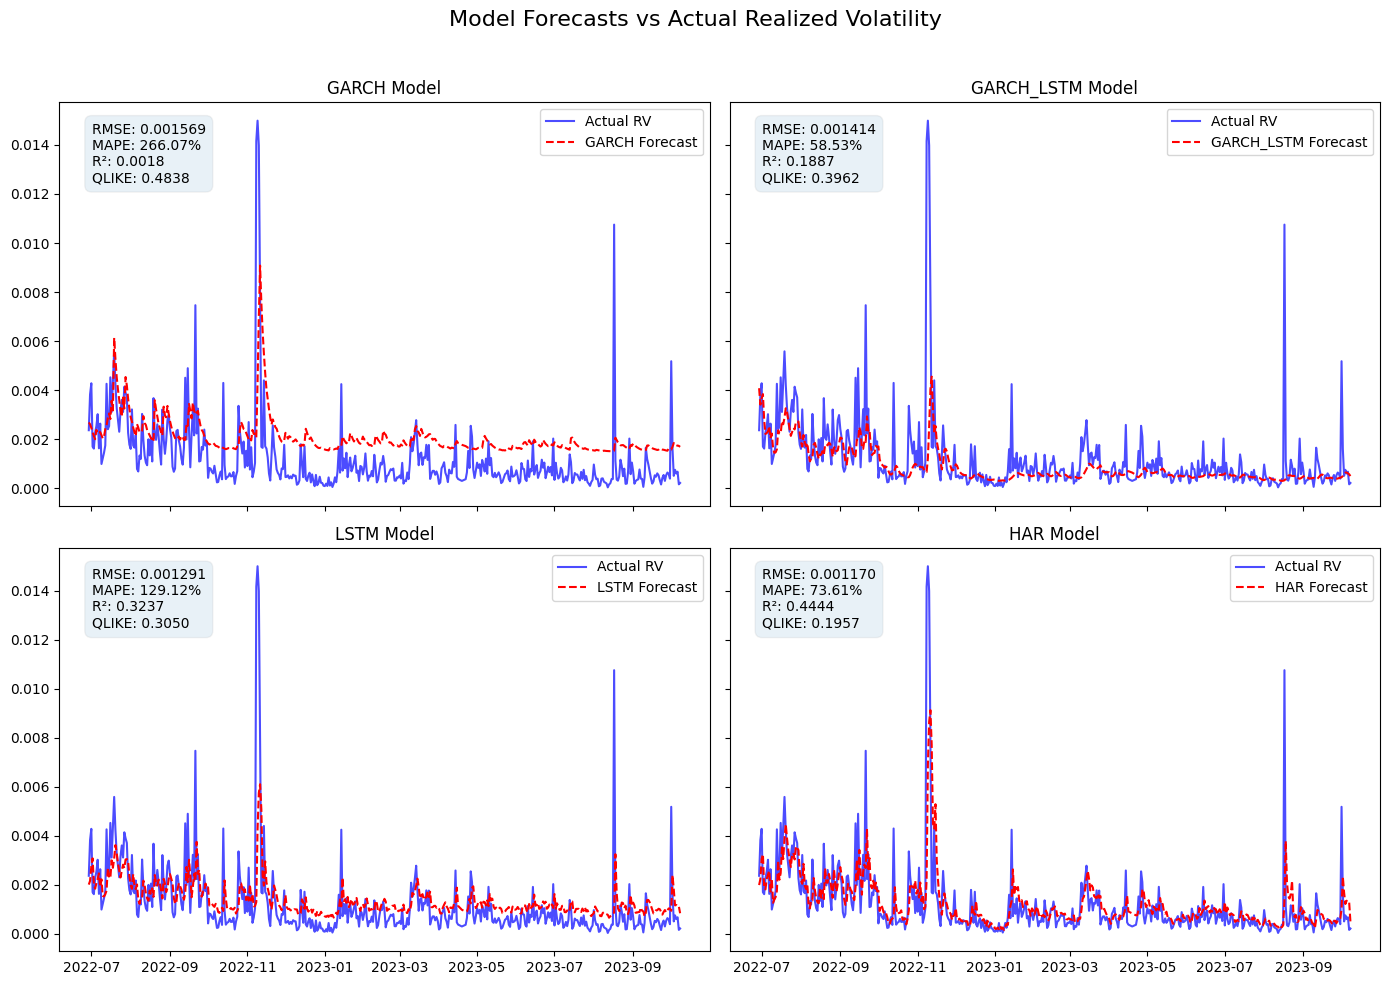

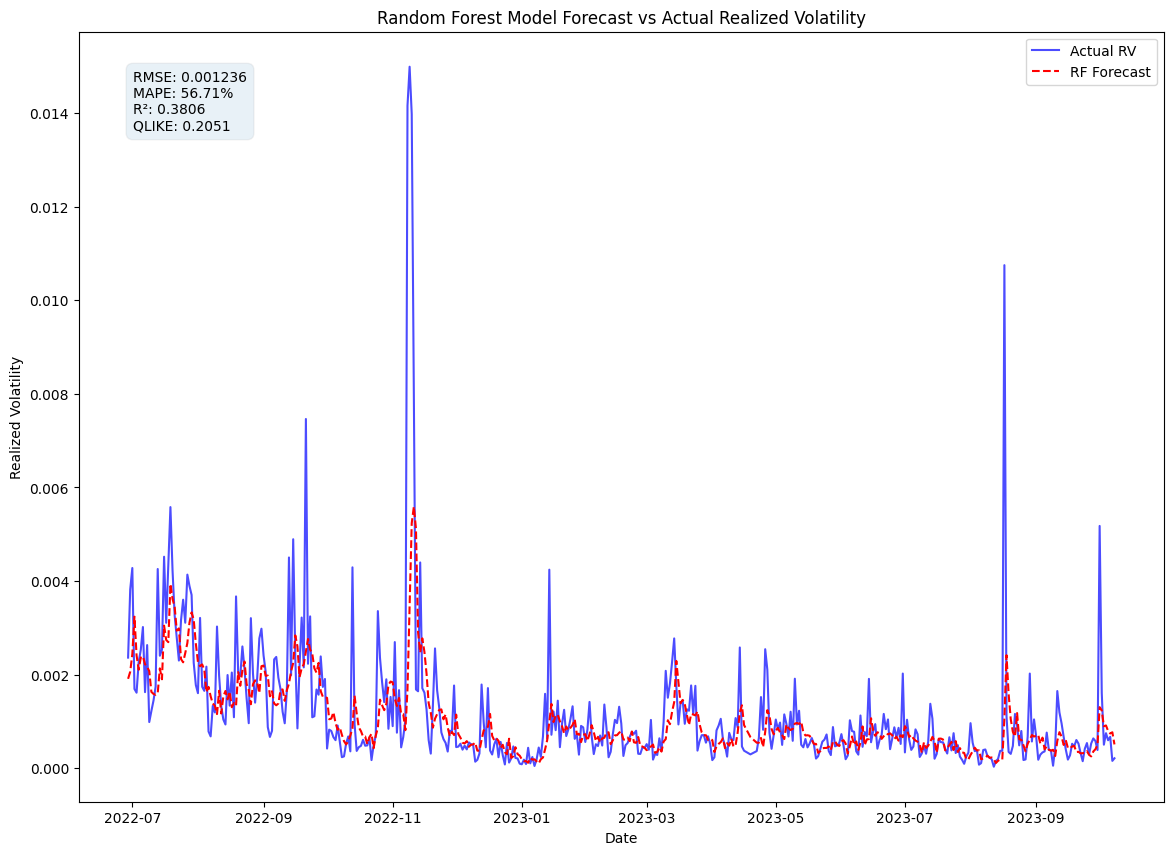

In [21]:
import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Model Forecasts vs Actual Realized Volatility', fontsize=16)

# Model names for titles
model_names = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR']

# Plot each model in the 2x2 grid
for ax, model, name in zip(axs.flatten(), models[:-1], model_names):
    ax.plot(data.index, data['Actual_RV'], label='Actual RV', color='blue', alpha=0.7)
    ax.plot(data.index, data[model], label=f'{name} Forecast', color='red', linestyle='dashed')
    ax.set_title(f'{name} Model')
    ax.legend()
    # Add metrics as text
    rmse, mape, r2 , qlike= metrics[model].values()
    rmse = float(rmse)
    mape = float(mape)
    r2 = float(r2)
    qlike = float(qlike)
    ax.text(0.05, 0.95, f'RMSE: {rmse:.6f}\nMAPE: {mape:.2%}\nR²: {r2:.4f} \nQLIKE: {qlike:.4f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', alpha=0.1, edgecolor='gray'))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Full-sized plot for the RF model
fig_rf, ax_rf = plt.subplots(figsize=(14, 10))
ax_rf.plot(data.index, data['Actual_RV'], label='Actual RV', color='blue', alpha=0.7)
ax_rf.plot(data.index, data['RF'], label='RF Forecast', color='red', linestyle='dashed')
ax_rf.set_title('Random Forest Model Forecast vs Actual Realized Volatility')
ax_rf.set_xlabel('Date')
ax_rf.set_ylabel('Realized Volatility')
ax_rf.legend()
# Add metrics as text
rmse, mape, r2, qlike = metrics['RF'].values()
# Convert to float if they are not already
rmse = float(rmse)
mape = float(mape)
r2 = float(r2)
qlike = float(qlike)
ax_rf.text(0.05, 0.95, f'RMSE: {rmse:.6f}\nMAPE: {mape:.2%}\nR²: {r2:.4f} \nQLIKE: {qlike:.4f}',
           transform=ax_rf.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round,pad=0.5', alpha=0.1, edgecolor='gray'))

# Show plots
plt.show()


Diebold-Mariano test

In [22]:
import pandas as pd
from dm_test import dm_test

# Ensure there are no missing values in the data
data = data.dropna()

# List of model forecast columns
model_columns = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR', 'RF']

# Initialize a list to store the results
results = []

# Perform pairwise Diebold-Mariano tests
for i in range(len(model_columns)):
    for j in range(i + 1, len(model_columns)):
        model1_name = model_columns[i]
        model2_name = model_columns[j]
        model1_forecast = np.log(data[model1_name].values)
        model2_forecast = np.log(data[model2_name].values)
        # Perform the Diebold-Mariano test
        dm_stat, p_value = dm_test(np.log(data['Actual_RV'].values), model1_forecast, model2_forecast, h=1, crit='MSE')
        # Append the results
        results.append((model1_name, model2_name, dm_stat, p_value))

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=['Model 1', 'Model 2', 'DM Statistic', 'P-Value'])

# Set significance level
alpha = 0.05

# Function to interpret DM test results
def interpret_dm_test(row, alpha):
    model1 = row['Model 1']
    model2 = row['Model 2']
    dm_stat = row['DM Statistic']
    p_value = row['P-Value']
    
    if p_value < alpha:
        if dm_stat > 0:
            conclusion = f"Significant difference; {model2} outperforms {model1}."
        else:
            conclusion = f"Significant difference; {model1} outperforms {model2}."
    else:
        conclusion = "No significant difference; similar predictive accuracy."
    
    return conclusion

# Apply the function to each row
results_df['Conclusion'] = results_df.apply(interpret_dm_test, axis=1, alpha=alpha)

# Display the DataFrame with conclusions
print(results_df[['Model 1', 'Model 2', 'DM Statistic', 'P-Value', 'Conclusion']])

results_df.to_csv('dm_test_results.csv', index=False)

      Model 1     Model 2  DM Statistic       P-Value  \
0       GARCH  GARCH_LSTM     11.887258  1.286809e-28   
1       GARCH        LSTM     17.668314  9.471585e-54   
2       GARCH         HAR     15.323805  3.761272e-43   
3       GARCH          RF     14.754369  1.210400e-40   
4  GARCH_LSTM        LSTM     -5.407092  1.029177e-07   
5  GARCH_LSTM         HAR      1.953718  5.133764e-02   
6  GARCH_LSTM          RF      4.325106  1.869344e-05   
7        LSTM         HAR      9.867043  5.761700e-21   
8        LSTM          RF      9.645949  3.509750e-20   
9         HAR          RF      3.377732  7.926740e-04   

                                          Conclusion  
0  Significant difference; GARCH_LSTM outperforms...  
1    Significant difference; LSTM outperforms GARCH.  
2     Significant difference; HAR outperforms GARCH.  
3      Significant difference; RF outperforms GARCH.  
4  Significant difference; GARCH_LSTM outperforms...  
5  No significant difference; similar pred

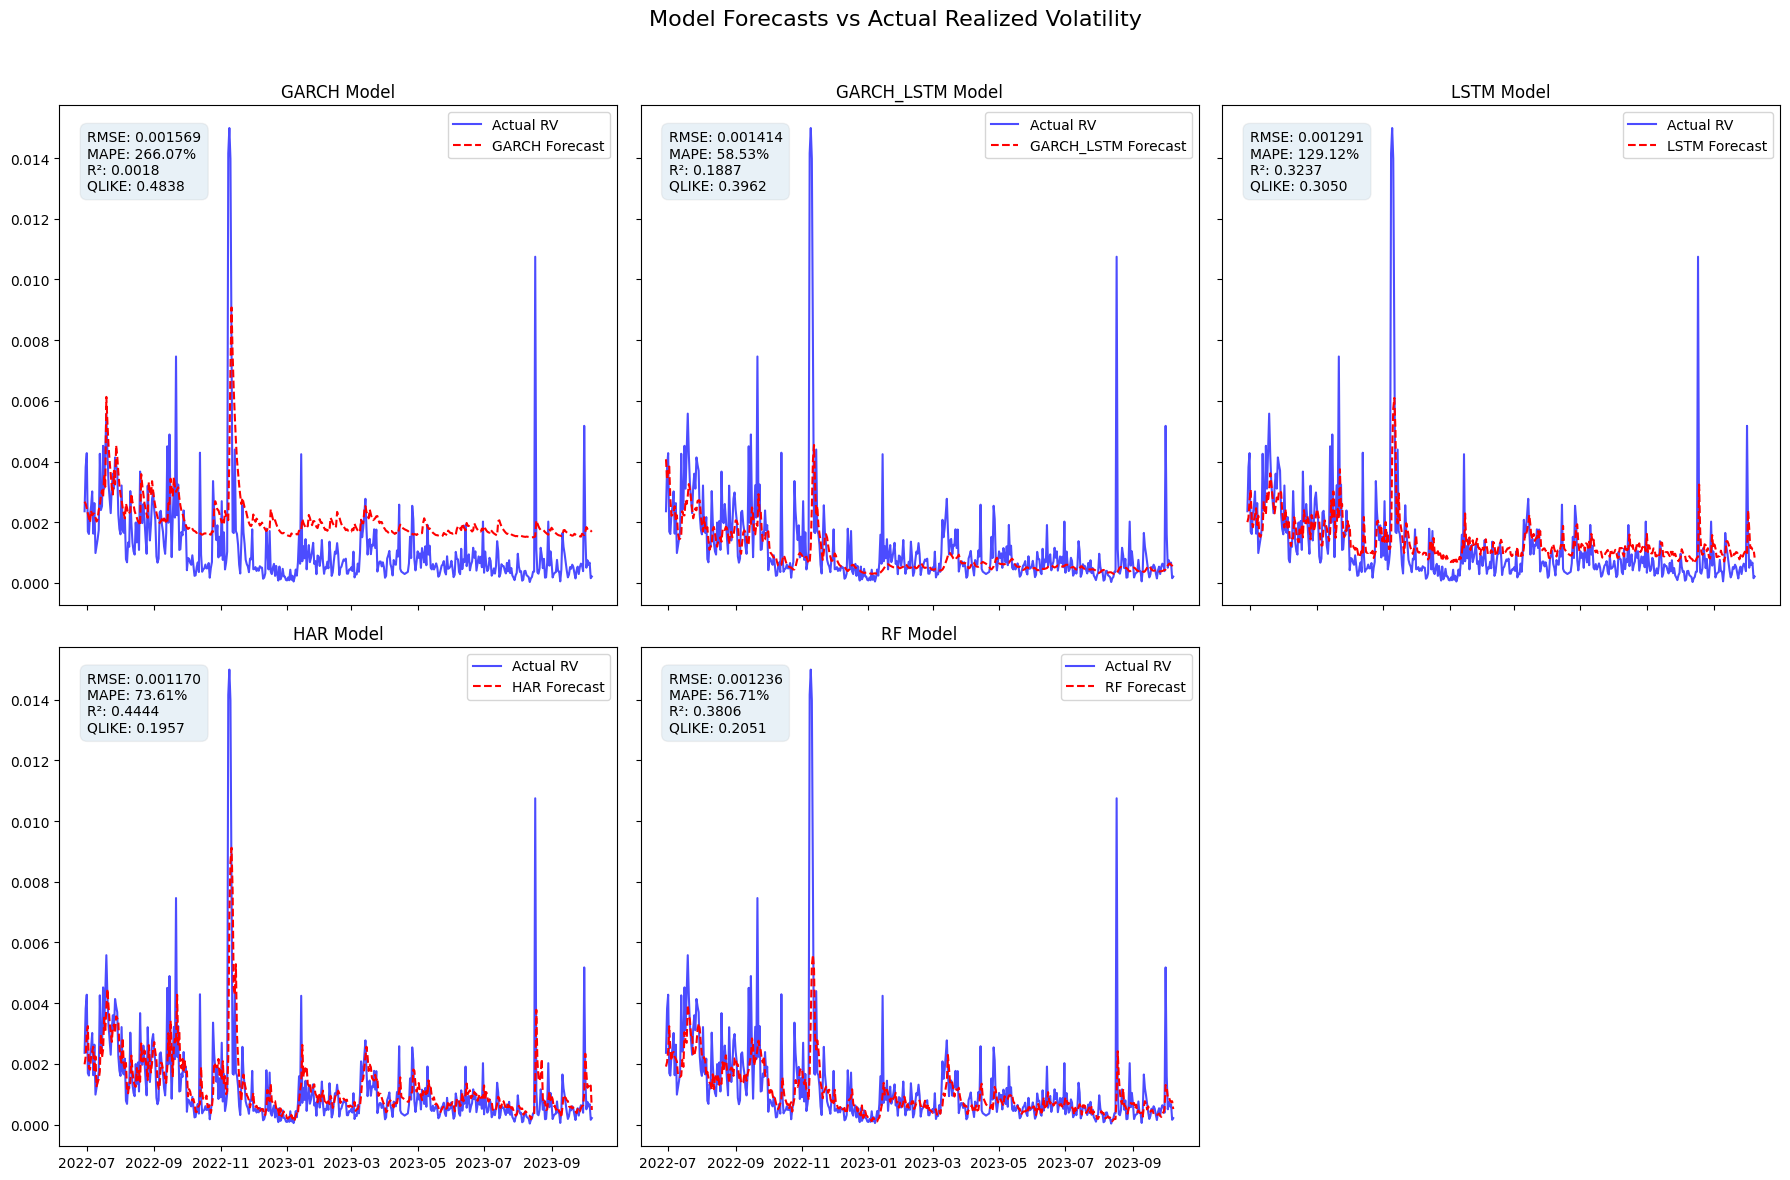

In [23]:
# Re-import necessary libraries since the execution state was reset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Creating a 2-row, 3-column grid (with last subplot empty for alignment)
fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
fig.suptitle('Model Forecasts vs Actual Realized Volatility', fontsize=16)

# Model names and corresponding data keys
model_names = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR', 'RF']
plot_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)]  # Positions in the grid

# Plot each model in the panel
for (row, col), model in zip(plot_positions, model_names):
    ax = axs[row, col]
    ax.plot(data.index, data['Actual_RV'], label='Actual RV', color='blue', alpha=0.7)
    ax.plot(data.index, data[model], label=f'{model} Forecast', color='red', linestyle='dashed')
    ax.set_title(f'{model} Model')
    ax.legend()
    
    # Add metrics as text
    rmse, mape, r2, qlike = metrics[model].values()
    rmse = float(rmse)
    mape = float(mape)
    r2 = float(r2)
    qlike = float(qlike)
    
    ax.text(0.05, 0.95, f'RMSE: {rmse:.6f}\nMAPE: {mape:.2%}\nR²: {r2:.4f}\nQLIKE: {qlike:.4f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', alpha=0.1, edgecolor='gray'))

# Hide the empty last subplot (bottom-right)
axs[1, 2].axis('off')

# Adjust layout for better visibility
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()


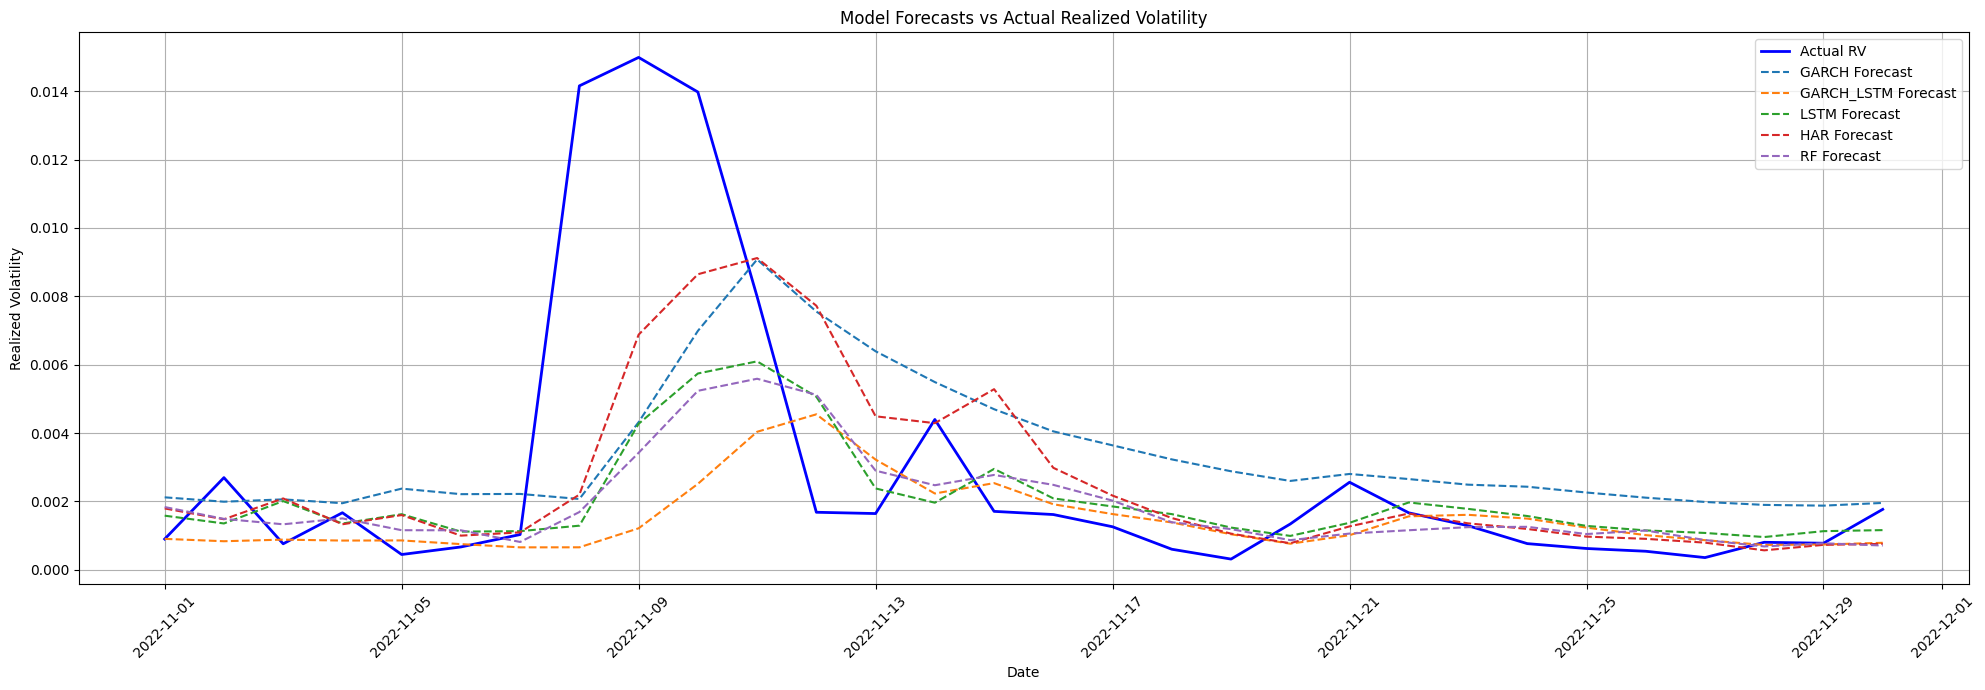

In [26]:
import matplotlib.pyplot as plt

def plot_forecasts(data, models, start_date, end_date):
    """
    Plots actual realized volatility and model forecasts within a specified date range.

    Parameters:
    - data: DataFrame containing 'Actual_RV' and model forecast columns with datetime index.
    - models: List of model names corresponding to columns in the data.
    - start_date: Start date as a string in 'YYYY-MM-DD' format.
    - end_date: End date as a string in 'YYYY-MM-DD' format.
    """
    # Filter data for the specified date range
    mask = (data.index >= start_date) & (data.index <= end_date)
    filtered_data = data.loc[mask]

    plt.figure(figsize=(20, 7))
    plt.plot(filtered_data.index, filtered_data['Actual_RV'], label='Actual RV', color='blue', linewidth=2)

    # Plot each model's forecast
    for model in models:
        plt.plot(filtered_data.index, filtered_data[model], label=f'{model} Forecast', linestyle='--')

    plt.title('Model Forecasts vs Actual Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Realized Volatility')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
model_names = ['GARCH', 'GARCH_LSTM', 'LSTM', 'HAR', 'RF']
plot_forecasts(data, model_names, '2022-11-01', '2022-11-30')
